Plotting a filament with noise added.  Load in the SB data file then pick exposure time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [83]:
def plotfilament(SBdata,ax,colmap='viridis',onlyyellow=False,contours=True,mockobs=False,labelaxes=False):
    # setting up the plot
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    Vmin = None
    Vmax= None
    #fig = plt.figure(figsize = (7.5, 8.))
    #ax = plt.subplot(121)
    fontsize=13

    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        #xlabels = [0,0.6,1.2,1.8,2.4,3.0]
        #ax.set_xticks([0,5,10,15,20,25], minor=False)
        #ax.set_xticklabels(xlabels, minor=False)
        #ylabels = [ 0.,0.25,0.5]
        #ax.set_yticks([0,2.5,5], minor=False)
        #ax.set_yticklabels(ylabels, minor=False)
    
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        ax.xaxis.set_label_position('top') 
        ax.xaxis.tick_top()
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
    #colmap = 'viridis'#'gist_gray'#'plasma'#'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value

    
    ## If you only want to plot the SB greater than 1 photon/s/cm^2/arcsec^2 then do the following
    if onlyyellow:
        SBonlyyellow = SBdata
        SBonlyyellow[SBdata<0.] = -3.
        img = ax.imshow(SBonlyyellow.T,origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = [0,1,2]
        colours = ['yellow','cyan','purple']
    else:
        img = ax.imshow(SBdata.T,origin='lower',extent=(0,3.7,0,0.7), cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = np.array([-2,-1,0,1,2,3])
        colours = ('red','orange','yellow','cyan','purple','pink')
        #levels = np.array([-2,-1.5,-1,-0.5,0,0.3,1,1.5,2,2.5,3])
        #colours = ('red','black','orange','black','yellow','black','cyan','black','purple','black','pink')
    
    # plot contours
    cmap = cm.PRGn
    if contours:
        ax.contour(SBdata.T,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)

    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("bottom",size="15%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    cbar.solids.set_edgecolor("face")
    cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
    #cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)


In [40]:
def addnoise(data,resolution,exptime=10**3*3600.,CMOS=False,addnoisesqrt=False):
    # Dragonfly info
    area_lens = np.pi*(14.3/2)**2 * 48.                 # cm^2, 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                      # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2      # rad^2, the pixel size of the CCD
    tau_l = 0.85                                        # transmittance of the Dragonfly lens
    tau_f = 1.                                          # transmittance of the Halpha filter -- assumed for now
    #B = getBackground(656.3,657.3,machine)              # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
    B = 0.560633
    D = 0.04                                            # dark current (electrons / s) 
    if CMOS:
        print "Using new CMOS cameras..."
        QE = 0.70                                       # quantum efficiency of the CMOS detector
        R_squared = 2.**2                               # read noise (electrons)
    else:
        print "Using old cameras..."
        QE = 0.48                                       # quantum efficiency of the CCDs
        R_squared = 10.**2                              # read noise (electrons)
    
   # R_squared = 50.**2
    
    binpix_size = resolution # arcsec
    numpixel = round((binpix_size/pix_size)**2)
    print "the number of pixels is %s"%numpixel
    
    
    ### total signal incident in exposure time ###
    totsignal = 10**data * exptime # ( photons / cm^2 /sr )
    ### total signal detected (accounting for system efficiency) ###
    detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    print "the total object signal [electrons] detected ranges from: %s to %s"%(np.min(detsignal),np.max(detsignal))
    print "an example of the object signal [electrons] is: %s"%detsignal[0]

    ### ObjectShotNoise ###
    detsignal_noise = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            detsignal_noise[x][y]=np.random.normal(detsignal[x][y],np.sqrt(detsignal[x][y])) 
    print "an example of the object signal noise [electrons] is: %s"%detsignal_noise[0]
    
    
    ### BackgroundSkyNoise ###
    'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
    print "the background in the bandwidth is: %s"%B
    print "the background signal, B_sky [ph/s (in a pixel)], is: %s"%B_sky
    B_sky_inexptime = B_sky*exptime
    B_sky_total     = B_sky*exptime*numpixel    
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.random.normal(B_sky_total,np.sqrt(B_sky_total)) 
#            B_sky_array[x][y]=np.random.poisson(B_sky_total)
    B_sky_array_total = B_sky_array
    print "the mean total background signal, B_sky_total [electrons], is: %s"%B_sky_total
    print "the total background noisy signal [electrons] ranges from: %s to %s"%(np.min(B_sky_array_total),np.max(B_sky_array_total))
    
    
    
    ### ReadOutNoise ###
    numexposures = exptime/3600. # hour long exposures
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
    R_squared_total = R_squared * round(numexposures)
    R_squared_total_array = R_squared_array * round(numexposures)
    print "the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s, %s"%(R_squared,numexposures,R_squared_total,R_squared_total_array[0])
    print "the total R_squared value [electrons] multiplying by numpix read out is: %s, %s"%((R_squared_total*numpixel),(R_squared_total_array[0]*numpixel))
    
    ### DarkCurrent ###
    D_total = D*exptime*numpixel
    D_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            D_array[x][y]=np.random.normal(D_total,np.sqrt(D_total)) 
    D_array_total = D_array
    print "the total dark current [electrons] is: %s , %s"%(D_total, D_array_total[0])

    sigma = np.sqrt(detsignal_noise + B_sky_array_total + D_array_total + R_squared_total_array*numpixel)
    print "an example total noise (not squarerooted) is: %s"%(detsignal + B_sky_array_total + D_array_total + R_squared_total_array*numpixel)[0]
    print "an example total noise (squarerooted) is: %s"%sigma[0]

    ###  The total signal = signal + noise, The noise is 'sigma' = sqrt(# photons). ###
    
    if addnoisesqrt:
        print "adding noise as sqrt(# photons)..."
        noiseadded_signal = np.log10(detsignal_noise + sigma) 
    else:
        print "adding noise as (# photons)..."
        noiseadded_signal = np.log10(sigma**2) 
    
    return B_sky_array_total,noiseadded_signal


Load the EAGLE SB data from a saved file:

In [77]:
resolution = 500. #arcsec
SBdata = np.load('SBdata_500arcsec.npz')['arr_0']

resolution = 1000. # arcsec
SBdata = np.load('SBdata_1000arcsec.npz')['arr_0']

resolution = 100. # arcsec
SBdata = np.load('SBdata_100arcsec.npz')['arr_0']

resolution = 13. # arcsec  (approximately)
SBdata = np.load('SBdata_full.npz')['arr_0']
print SBdata.shape

(1121, 225)


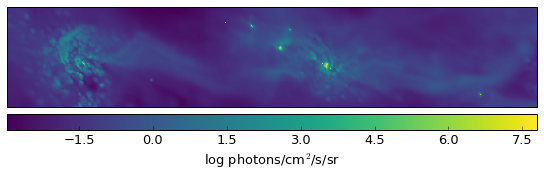

In [84]:
fig = plt.figure(figsize = (9.5, 5.))
ax1 = plt.subplot(111)

plotfilament(SBdata,ax1,contours=False,labelaxes=False)

Add noise to the data and plot it.

Choose the exposure time and whether you want to add the noise as sqrt(# photons) [addnoisesqrt = True] or straight up add the full (# photons) from the background/system [addnoisesqrt = False].

Using new CMOS cameras...
the number of pixels is 127551.0
the total object signal [electrons] detected ranges from: 37726743.6433 to 6.81534556389e+14
an example of the object signal [electrons] is: [  7.22018848e+07   2.63533377e+08   7.78285473e+08   1.41830583e+09]
an example of the object signal noise [electrons] is: [  7.22040016e+07   2.63532451e+08   7.78272919e+08   1.41827871e+09]
the background in the bandwidth is: 0.560633
the background signal, B_sky [ph/s (in a pixel)], is: 2.01611304518
the mean total background signal, B_sky_total [electrons], is: 9.25766046094e+16
the total background noisy signal [electrons] ranges from: 9.25766036124e+16 to 9.25766053554e+16
the R_squared value is: 4.0, so in 100000000.0 exposures [per pixel], will have R_squared of: 400000000.0, [  4.01427815e+08   4.01198615e+08   3.99618777e+08   4.01143493e+08]
the total R_squared value [electrons] multiplying by numpix read out is: 5.10204e+13, [  5.12025192e+13   5.11732845e+13   5.09717746e+13

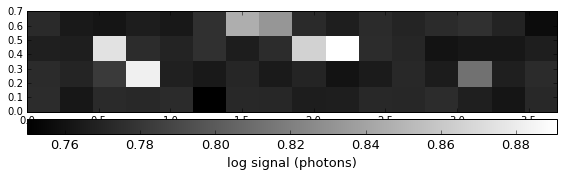

In [68]:
exptime=10**8*3600.
addnoisesqrt = False

#  Add the noise to the EAGLE SB data
b_sky_total,SBdata_exp0 = addnoise(SBdata,resolution,exptime=exptime,CMOS=True,addnoisesqrt=addnoisesqrt)

#  Subtract a background value
mockobs_sub = SBdata_exp0 - (int(np.min(SBdata_exp0)*1000000)/1000000.)

# Plot the subtracted noiseadded data
fig = plt.figure(figsize = (9.5, 5.))
ax1 = plt.subplot(111)

plotfilament(mockobs_sub**0.02,ax1,contours=False,mockobs=True,colmap='gist_gray')

#plt.savefig('mockobs_res%sas_exptime%shr.png'%(resolution,round(exptime/3600.)))

(array([  6.,  14.,  26.,  51.,  45.,  32.,  17.,  15.,   3.,   1.]),
 array([  2.31442996e+12,   2.31443073e+12,   2.31443150e+12,
          2.31443227e+12,   2.31443304e+12,   2.31443381e+12,
          2.31443458e+12,   2.31443535e+12,   2.31443612e+12,
          2.31443688e+12,   2.31443765e+12]),
 <a list of 10 Patch objects>)

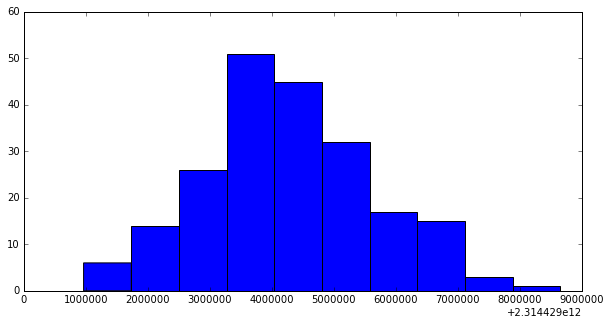

In [61]:
plt.figure(figsize = (10,5))
plt.hist((b_sky_total.flatten()),bins=10)

(array([  6.,  14.,  26.,  51.,  45.,  32.,  17.,  15.,   3.,   1.]),
 array([ 1521325.06781259,  1521325.32062075,  1521325.5734289 ,
         1521325.82623705,  1521326.0790452 ,  1521326.33185336,
         1521326.58466151,  1521326.83746966,  1521327.09027782,
         1521327.34308597,  1521327.59589412]),
 <a list of 10 Patch objects>)

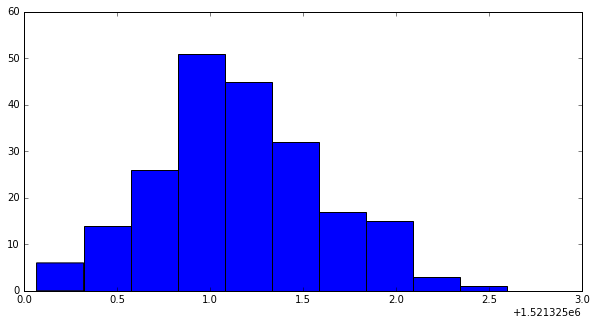

In [59]:
plt.figure(figsize = (10,5))
plt.hist(np.sqrt(b_sky_total.flatten()))

In [37]:
test

array([[  1.27311429e-05,   1.33161822e-05,   1.05311971e-05,
          1.10582729e-05,   1.02463996e-05,   1.05880092e-05,
          1.03590853e-05],
       [  1.21269871e-05,   1.10869693e-05,   7.54350702e-06,
          1.33180376e-05,   8.86654835e-06,   1.23240762e-05,
          9.93393335e-06],
       [  8.64823563e-06,   1.06313206e-05,   9.95830632e-06,
          1.04600901e-05,   9.66757554e-06,   1.13526720e-05,
          1.07504059e-05],
       [  1.07520825e-05,   1.40225306e-05,   1.30030155e-05,
          2.24283862e-05,   1.20653856e-05,   1.01771788e-05,
          1.20562205e-05],
       [  1.27801225e-05,   1.15030774e-05,   1.82802976e-05,
          5.16769200e-03,   1.20880472e-05,   1.13014138e-05,
          9.61575450e-06],
       [  1.15235484e-05,   7.83550477e-03,   1.22083578e-05,
          1.22743440e-05,   9.36150360e-06,   1.24156184e-05,
          9.58453744e-06],
       [  8.99228698e-06,   1.30936735e-05,   1.09101283e-05,
          1.36620763e-05,   1.32

In [38]:
test= mockobs_sub[:][:]

In [39]:
test

array([[  1.27311429e-05,   1.33161822e-05,   1.05311971e-05,
          1.10582729e-05,   1.02463996e-05,   1.05880092e-05,
          1.03590853e-05],
       [  1.21269871e-05,   1.10869693e-05,   7.54350702e-06,
          1.33180376e-05,   8.86654835e-06,   1.23240762e-05,
          9.93393335e-06],
       [  8.64823563e-06,   1.06313206e-05,   9.95830632e-06,
          1.04600901e-05,   9.66757554e-06,   1.13526720e-05,
          1.07504059e-05],
       [  1.07520825e-05,   1.40225306e-05,   1.30030155e-05,
          2.24283862e-05,   1.20653856e-05,   1.01771788e-05,
          1.20562205e-05],
       [  1.27801225e-05,   1.15030774e-05,   1.82802976e-05,
          5.16769200e-03,   1.20880472e-05,   1.13014138e-05,
          9.61575450e-06],
       [  1.15235484e-05,   7.83550477e-03,   1.22083578e-05,
          1.22743440e-05,   9.36150360e-06,   1.24156184e-05,
          9.58453744e-06],
       [  8.99228698e-06,   1.30936735e-05,   1.09101283e-05,
          1.36620763e-05,   1.32

In [87]:
100./32000./(0.237/1000. * (1.0115))

13.035742964348808

In [86]:
0.237/1000. * (1.0115)

0.0002397255

In [88]:
(0.237/1000. * (1.0115))*10/(100./32000.)

0.7671216